# FIFS Sports Big Data Gamethon 2025  

## **Resources**  
Here are key data sources for the competition:  
- **Cricinfo Stats Repository:** [ESPN Cricinfo Stats](https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;type=batting)  
- **Cricsheet:** [Cricsheet.org](https://cricsheet.org/)  

---

## **Overview**  
The **FIFS Sports Big Data Gamethon 2025** is an AI/ML-powered competition that challenges participants to develop predictive models for **fantasy cricket team selection** during the **ICC Champions Trophy 2025** (Feb 19 - Mar 9, 2025). The goal is to maximize **fantasy points** across all matches by selecting optimal teams based on historical performance, match conditions, and real-time constraints.  

---

## **Objectives of this Notebook**  
This notebook serves as an **introduction to the competition**, outlining the **rules, constraints, and evaluation criteria**. It also lays the foundation for data collection, feature engineering, and model development.  

### **Key Goals**  
- Understand the **gameplay rules** for team selection, budget constraints, and scoring system.  
- Identify the **factors influencing player selection**, such as form, venue, and match conditions.  
- Outline the strategy for **building an AI/ML model** to optimize fantasy team selection.  

---

## **Gameplay Rules & Constraints**  

<details>
  <summary>Team Composition (Click to expand)</summary>  

- A fantasy team consists of **11 players**, matching real-life teams.  
- Each team must include **at least 1 player from both competing teams** in a match.  
- The team must have **at least one player from each category**:  
  - **Wicketkeepers (WK)**  
  - **Batters (BAT)**  
  - **All-rounders (AR)**  
  - **Bowlers (BOWL)**  

</details>  

<details>
  <summary>Budget & Player Credits (Click to expand) </summary>  

- Every player is assigned a **credit value** based on their performance and demand.  
- Participants are given a **budget of 100 player credits** to select their **11 players**.  

</details>  

<details>
  <summary>Backups & Player Replacements (Click to expand) </summary>  

- Participants can select **up to 4 backup players** in case a selected player is not in the final playing XI.  
- Backup players will **only replace non-announced players** and must satisfy all **team composition rules**.  
- ⚠️ Example: If you only select **one bowler** and they are dropped from the playing XI, but none of your backups are bowlers, then the team selection will be invalid.  

</details>  

<details>
  <summary>Fantasy Points System (Click to expand) </summary>  

- Players earn points based on their **match performance** (batting, bowling, fielding).  
- The **official scoring system** for the ICC Champions Trophy can be found **[here](https://www.dream11.com/games/fantasy-cricket/how-to-play?ln=en-US)** under the **One Day (OD) tab**.  

</details>  

---

## **📊 Data Provided**  

<details>
  <summary>Data Sources & Availability (Click to expand) </summary>  

1. **Cricinfo Stats Repository** → [Link](https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;type=batting)  
2. **Cricsheet** → [Link](https://cricsheet.org/) 

</details>  

---

## **Expected Outcomes**  
By the end of this project, we aim to:  
**Understand the constraints and optimize team selection strategies.**  
**Analyze historical data to extract meaningful player performance trends.**  
**Develop an AI/ML-based model to predict and select the best teams dynamically.**  
**Ensure compliance with fantasy cricket rules while maximizing points.**  

This introduction sets the foundation for our data-driven approach to **fantasy cricket optimization**.

# Data collection

### About the data

A zip archive contains data files from Cricsheet in JSON format. This
archive contains 2887 ODI matches. A further 146 matches have been withheld
due to either featuring the Afghanistan men's team or being played in the
Afghanistan Premier League, due to the Cricsheet policy to no longer feature
matches involving Afghanistan men or played in Afghanistan Premier League (see
https://cricsheet.org/withheld-matches for more information).


The JSON data files contained in this zip file are version 1.0.0, and 1.1.0
files. You can learn about the structure of these files at
https://cricsheet.org/format/json/


You can find the available downloads at https://cricsheet.org/downloads/, and
you can find the most up-to-date version of this zip file at
https://cricsheet.org/downloads/odis_json.zip


The matches contained in this zip archive are listed below. The first field is
the start date of the match (for test matches or other multi-day matches), or
the actual date (for all other types of match). The second is the type of
teams involved, whether 'club', or 'international'. The third is the type of
match, either Test, ODI, ODM, T20, IT20, MDM, or a club competition code (such
as IPL). The 4th field is the gender of the players involved in the match. The
5th field is the id of the match, and the remainder of the line shows the
teams involved in the match.

In [1]:
# !pip3 install beautifulsoup4 requests pandas lxml -q

In [2]:
import os
import json
import pandas as pd
import numpy as np

In [3]:
json_folder = './odis_json/'
csv_folder = './odi_csv/'
output_folder = './output/'

match_summary_list = []
player_stats_dict = {}
match_timeseries_data = []

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [4]:
print("Starting the process of reading JSON files from the folder:", json_folder)
print(f"Found {len(os.listdir(json_folder))} files")

print("\n\nProcessing data...")
for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(json_folder, filename)

        try:
            with open(file_path, 'r') as file:
                data = json.load(file)
                total_fours = 0
                total_sixes = 0

                match_info = {
                    "match_id": filename.split('.')[0],  # Use filename as match ID
                    "created": data.get("meta", {}).get("created"),
                    "city": data.get("info", {}).get("city"),
                    "dates": data.get("info", {}).get("dates", [])[0] if data.get("info", {}).get("dates") else None,
                    "event_name": data.get("info", {}).get("event", {}).get("name"),
                    "match_number": data.get("info", {}).get("event", {}).get("match_number"),
                    "gender": data.get("info", {}).get("gender"),
                    "match_type": data.get("info", {}).get("match_type"),
                    "match_type_number": data.get("info", {}).get("match_type_number"),
                    "toss_winner": data.get("info", {}).get("toss", {}).get("winner"),
                    "toss_decision": data.get("info", {}).get("toss", {}).get("decision"),
                    "outcome_winner": data.get("info", {}).get("outcome", {}).get("winner"),
                    "outcome_by_runs": data.get("info", {}).get("outcome", {}).get("by", {}).get("runs"),
                    "outcome_by_wickets": data.get("info", {}).get("outcome", {}).get("by", {}).get("wickets"),
                    "overs": data.get("info", {}).get("overs"),
                    "player_of_match": data.get("info", {}).get("player_of_match", [])[0] if data.get("info", {}).get("player_of_match") else None,
                    "season": data.get("info", {}).get("season"),
                    "teams": ", ".join(data.get("info", {}).get("teams", [])),
                    "venue": data.get("info", {}).get("venue")
                }

                innings_data = data.get("innings", [])
                match_timeseries_data = []

                # Track match outcome
                match_winner = match_info["outcome_winner"]
                match_loser = None
                if match_winner:
                    match_loser = [team for team in data.get("info", {}).get("teams", []) if team != match_winner][0]

                # Iterate over innings to capture time-series data
                for inning in innings_data:
                    team = inning.get("team")
                    for over_data in inning.get("overs", []):
                        over_number = over_data.get("over")
                        for delivery in over_data.get("deliveries", []):
                            runs_scored = delivery.get("runs", {}).get("batter", 0)
                            if runs_scored == 4:
                                total_fours += 1
                            elif runs_scored == 6:
                                total_sixes += 1
                            delivery_info = {
                                "match_id": match_info["match_id"],
                                "team": team,
                                "over": over_number,
                                "ball": delivery.get("ball"),
                                "batter": delivery.get("batter"),
                                "bowler": delivery.get("bowler"),
                                "non_striker": delivery.get("non_striker"),
                                "runs_batter": delivery.get("runs", {}).get("batter", 0),
                                "runs_extras": delivery.get("runs", {}).get("extras", 0),
                                "runs_total": delivery.get("runs", {}).get("total", 0),
                                "wicket_player_out": delivery.get("wickets", [{}])[0].get("player_out", None),
                                "wicket_kind": delivery.get("wickets", [{}])[0].get("kind", None)
                            }
                            match_timeseries_data.append(delivery_info)

                            # Player stats aggregation for batting
                            batter = delivery.get("batter")
                            if batter:
                                if batter not in player_stats_dict:
                                    player_stats_dict[batter] = {
                                        "player_name": batter,
                                        "role": "Batter",
                                        "total_runs": 0,
                                        "strike_rate": 0,
                                        "total_balls_faced": 0,
                                        "total_wickets_taken": 0,
                                        "total_runs_conceded": 0,
                                        "total_overs_bowled": 0,
                                        "total_matches_played": 0,
                                        "matches_played_as_batter": 0,
                                        "matches_played_as_bowler": 0,
                                        "matches_won": 0,
                                        "matches_lost": 0,
                                        "player_of_match_awards": 0,
                                        "team": team
                                    }
                                player_stats_dict[batter]["total_runs"] += delivery.get("runs", {}).get("batter", 0)
                                player_stats_dict[batter]["total_balls_faced"] += 1
                                player_stats_dict[batter]["strike_rate"] = (player_stats_dict[batter]["total_runs"] / player_stats_dict[batter]["total_balls_faced"]) * 100

                            # Player stats aggregation for bowling
                            bowler = delivery.get("bowler")
                            if bowler:
                                if bowler not in player_stats_dict:
                                    player_stats_dict[bowler] = {
                                        "player_name": bowler,
                                        "role": "Bowler",
                                        "total_runs": 0,
                                        "strike_rate": 0,
                                        "total_balls_faced": 0,
                                        "total_wickets_taken": 0,
                                        "total_runs_conceded": 0,
                                        "total_overs_bowled": 0,
                                        "total_matches_played": 0,
                                        "matches_played_as_batter": 0,
                                        "matches_played_as_bowler": 0,
                                        "matches_won": 0,
                                        "matches_lost": 0,
                                        "player_of_match_awards": 0,
                                        "team": team
                                    }
                                player_stats_dict[bowler]["total_runs_conceded"] += delivery.get("runs", {}).get("total", 0)
                                player_stats_dict[bowler]["total_overs_bowled"] += 1

                                # Wickets taken by bowler
                                if delivery.get("wickets"):
                                    player_stats_dict[bowler]["total_wickets_taken"] += 1
                match_info["total_fours"] = total_fours
                match_info["total_sixes"] = total_sixes
                
                # Update match win/loss for players
                if match_winner:
                    for player in player_stats_dict.values():
                        if player["team"] == match_winner:
                            player["matches_won"] += 1
                        elif player["team"] == match_loser:
                            player["matches_lost"] += 1

                # Update player_of_match for award tracking
                player_of_match = match_info["player_of_match"]
                if player_of_match and player_of_match in player_stats_dict:
                    player_stats_dict[player_of_match]["player_of_match_awards"] += 1

                if match_timeseries_data:
                    df_timeseries = pd.DataFrame(match_timeseries_data)
                    output_csv_path = os.path.join(csv_folder, f"{filename.split('.')[0]}.csv")
                    df_timeseries.to_csv(output_csv_path, index=False)

                match_summary_list.append(match_info)
                
        except json.JSONDecodeError as e:
            print(f"Error: Failed to decode JSON in {filename}. Error: {e}")
        except Exception as e:
            print(f"Error: An unexpected error occurred while processing {filename}. Error: {e}")

# Create match summary DataFrame
if match_summary_list:
    try:
        df_summary = pd.DataFrame(match_summary_list)
        print("Successfully created a DataFrame with the match summary data.")
        print("Summary DataFrame shape:", df_summary.shape)
        # Save the match summary CSV
        df_summary.to_csv(os.path.join(output_folder, 'match_summary.csv'), index=False)
    except Exception as e:
        print(f"Error: Failed to create match summary DataFrame. Error: {e}")

# Separate player stats for batters and bowlers
batters_data = []
bowlers_data = []
if player_stats_dict:
    try:
        for player, stats in player_stats_dict.items():
            if stats["role"] == "Batter":
                # Calculate batting average and strike rate for batters
                if stats["total_balls_faced"] > 0:
                    stats["strike_rate"] = (stats["total_runs"] / stats["total_balls_faced"]) * 100
                if stats["total_wickets_taken"] > 0:
                    stats["average"] = stats["total_runs"] / stats["total_wickets_taken"]
                batters_data.append(stats)
            elif stats["role"] == "Bowler":
                # Calculate bowling economy rate and average for bowlers
                if stats["total_overs_bowled"] > 0:
                    stats["economy_rate"] = stats["total_runs_conceded"] / stats["total_overs_bowled"]
                if stats["total_wickets_taken"] > 0:
                    stats["average"] = stats["total_runs_conceded"] / stats["total_wickets_taken"]
                bowlers_data.append(stats)

        # Create DataFrames for batters and bowlers
        batter_df = pd.DataFrame(batters_data)
        bowler_df = pd.DataFrame(bowlers_data)

        # Additional statistics for batters and bowlers
        batter_df["total_matches_played"] = batter_df["matches_won"] + batter_df["matches_lost"]
        batter_df["matches_played_as_batter"] = batter_df["total_matches_played"]

        bowler_df["total_matches_played"] = bowler_df["matches_won"] + bowler_df["matches_lost"]
        bowler_df["matches_played_as_bowler"] = bowler_df["total_matches_played"]

        print("Successfully created a DataFrame with player statistics.")
        print("Batters Stats DataFrame shape:", batter_df.shape)
        print("Bowlers Stats DataFrame shape:", bowler_df.shape)

        # Save the separate CSVs for batters and bowlers
        batter_df.to_csv(os.path.join(output_folder, 'batter_player_stats.csv'), index=False)
        bowler_df.to_csv(os.path.join(output_folder, 'bowler_player_stats.csv'), index=False)

    except Exception as e:
        print(f"Error: Failed to create player statistics DataFrame. Error: {e}")

print("Process completed.")

Starting the process of reading JSON files from the folder: ./odis_json/
Found 2888 files


Processing data...
Successfully created a DataFrame with the match summary data.
Summary DataFrame shape: (2887, 21)
Successfully created a DataFrame with player statistics.
Batters Stats DataFrame shape: (1540, 16)
Bowlers Stats DataFrame shape: (929, 17)
Process completed.


In [5]:
df_summary.head()

,match_id,created,city,dates,event_name,match_number,gender,match_type,match_type_number,toss_winner,...,outcome_winner,outcome_by_runs,outcome_by_wickets,overs,player_of_match,season,teams,venue,total_fours,total_sixes
0,1387601,2023-12-19,Gqeberha,2023-12-19,India tour of South Africa,2.0,male,ODI,4714,South Africa,...,South Africa,NaN,8.0,50,T de Zorzi,2023/24,"India, South Africa","St George's Park, Gqeberha",41,10
1,467883,2010-11-29,Guwahati,2010-11-28,New Zealand in India ODI Series,1.0,male,ODI,3070,New Zealand,...,India,40.0,NaN,50,V Kohli,2010/11,"India, New Zealand",Nehru Stadium,53,6
2,351689,2013-03-04,Perth,2009-02-01,Chappell-Hadlee Trophy,1.0,male,ODI,2811,Australia,...,New Zealand,NaN,2.0,50,KD Mills,2008/09,"Australia, New Zealand",Western Australia Cricket Association Ground,25,4
3,1253268,2021-03-10,Lucknow,2021-03-09,South Africa Women tour of India,2.0,female,ODI,1191,India,...,India,NaN,9.0,50,J Goswami,2020/21,"South Africa, India",Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,34,3
4,1312806,2022-06-12,Pearland,2022-06-11,ICC Men's Cricket World Cup League 2,87.0,male,ODI,4406,Nepal,...,None,NaN,NaN,50,SR Taylor,2022,"Nepal, United States of America","Moosa Cricket Stadium, Pearland",35,9


In [6]:
df = df_summary[df_summary['gender'] == 'male'].copy()
df.loc[:, 'created'] = pd.to_datetime(df['created'])

In [7]:
df.head()

,match_id,created,city,dates,event_name,match_number,gender,match_type,match_type_number,toss_winner,...,outcome_winner,outcome_by_runs,outcome_by_wickets,overs,player_of_match,season,teams,venue,total_fours,total_sixes
0,1387601,2023-12-19 00:00:00,Gqeberha,2023-12-19,India tour of South Africa,2.0,male,ODI,4714,South Africa,...,South Africa,NaN,8.0,50,T de Zorzi,2023/24,"India, South Africa","St George's Park, Gqeberha",41,10
1,467883,2010-11-29 00:00:00,Guwahati,2010-11-28,New Zealand in India ODI Series,1.0,male,ODI,3070,New Zealand,...,India,40.0,NaN,50,V Kohli,2010/11,"India, New Zealand",Nehru Stadium,53,6
2,351689,2013-03-04 00:00:00,Perth,2009-02-01,Chappell-Hadlee Trophy,1.0,male,ODI,2811,Australia,...,New Zealand,NaN,2.0,50,KD Mills,2008/09,"Australia, New Zealand",Western Australia Cricket Association Ground,25,4
4,1312806,2022-06-12 00:00:00,Pearland,2022-06-11,ICC Men's Cricket World Cup League 2,87.0,male,ODI,4406,Nepal,...,None,NaN,NaN,50,SR Taylor,2022,"Nepal, United States of America","Moosa Cricket Stadium, Pearland",35,9
5,1377005,2023-06-06 00:00:00,Sharjah,2023-06-04,West Indies tour of United Arab Emirates,1.0,male,ODI,4581,United Arab Emirates,...,West Indies,NaN,7.0,50,BA King,2023,"United Arab Emirates, West Indies",Sharjah Cricket Stadium,35,11


In [8]:
df.size

50400

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 0 to 2886
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            2400 non-null   object 
 1   created             2400 non-null   object 
 2   city                2119 non-null   object 
 3   dates               2400 non-null   object 
 4   event_name          2386 non-null   object 
 5   match_number        2290 non-null   float64
 6   gender              2400 non-null   object 
 7   match_type          2400 non-null   object 
 8   match_type_number   2400 non-null   int64  
 9   toss_winner         2400 non-null   object 
 10  toss_decision       2400 non-null   object 
 11  outcome_winner      2277 non-null   object 
 12  outcome_by_runs     1107 non-null   float64
 13  outcome_by_wickets  1170 non-null   float64
 14  overs               2400 non-null   int64  
 15  player_of_match     2258 non-null   object 
 16  season     

# Get detailed player stats

| **Feature**                            | **Description**                                                  |
| -------------------------------------- | ---------------------------------------------------------------- |
| **Player Name**                        | Name of the player                                               |
| **Match ID**                           | Unique match identifier                                          |
| **Team**                               | Team of the player                                               |
| **Runs Scored (`runs`)**               | Total runs scored by the player                                  |
| **Balls Faced (`balls_faced`)**        | Number of balls faced by the player                              |
| **Fours (`fours`)**                    | Number of fours hit by the player                                |
| **Sixes (`sixes`)**                    | Number of sixes hit by the player                                |
| **Strike Rate (`strike_rate`)**        | Batting strike rate (calculated)                                 |
| **Wickets Taken (`wickets`)**          | Number of wickets taken by the bowler                            |
| **Maiden Over (`maiden`)**             | Number of overs in which no runs are scored                      |
| **Overs Bowled (`overs_bowled`)**      | Number of overs bowled by the player                             |
| **Balls Bowled (`balls_bowled`)**      | Total balls bowled by the player                                 |
| **Runs Conceded (`runs_conceded`)**    | Runs conceded by the bowler                                      |
| **Economy Rate (`economy`)**           | Bowling economy rate (calculated)                                |
| **Catches (`catches`)**                | Number of catches taken by the player                            |
| **Run Outs (`run_outs`)**              | Number of run outs contributed by the player (if available)      |
| **Match Outcome (`match_outcome`)**    | Whether the player’s team won or lost (win/loss)                 |
| **Player Role (Captain/Vice-Captain)** | Whether the player is a captain, vice-captain, or regular player |


In [10]:
def calculate_fantasy_points(stats):
    fantasy_points = 0

    # Batting Points
    fantasy_points += stats["runs"]  # 1 point per run
    fantasy_points += stats["fours"] * 4  # 4 points per boundary
    fantasy_points += stats["sixes"] * 6  # 6 points per six

    if stats["runs"] >= 25:
        fantasy_points += 4
    if stats["runs"] >= 50:
        fantasy_points += 8
    if stats["runs"] >= 75:
        fantasy_points += 12
    if stats["runs"] >= 100:
        fantasy_points += 16
    if stats["runs"] >= 125:
        fantasy_points += 20
    if stats["runs"] >= 150:
        fantasy_points += 24

    if stats["balls_faced"] > 0 and stats["runs"] == 0:  # Duck dismissal
        fantasy_points -= 3

    # Strike Rate Points (min 20 balls faced)
    if stats["balls_faced"] >= 20:
        if stats["strike_rate"] > 140:
            fantasy_points += 6
        elif 120.01 <= stats["strike_rate"] <= 140:
            fantasy_points += 4
        elif 100 <= stats["strike_rate"] <= 120:
            fantasy_points += 2
        elif 40 <= stats["strike_rate"] <= 50:
            fantasy_points -= 2
        elif 30 <= stats["strike_rate"] <= 39.99:
            fantasy_points -= 4
        elif stats["strike_rate"] < 30:
            fantasy_points -= 6

    # Bowling Points
    fantasy_points += stats["wickets"] * 25  # 25 points per wicket
    fantasy_points += stats["maiden"] * 4  # 4 points per maiden over
    fantasy_points += (stats["balls_bowled"] // 3) * 1  # 1 point per 3 dot balls

    if stats["wickets"] >= 4:
        fantasy_points += 4
    if stats["wickets"] >= 5:
        fantasy_points += 8
    if stats["wickets"] >= 6:
        fantasy_points += 12

    # Bonus for LBW or Bowled
    fantasy_points += stats.get("lbw_bowled", 0) * 8

    # Economy Rate Points (min 5 overs bowled)
    if stats["overs_bowled"] >= 5:
        if stats["economy"] < 2.5:
            fantasy_points += 6
        elif 2.5 <= stats["economy"] <= 3.49:
            fantasy_points += 4
        elif 3.5 <= stats["economy"] <= 4.5:
            fantasy_points += 2
        elif 7 <= stats["economy"] <= 8:
            fantasy_points -= 2
        elif 8.01 <= stats["economy"] <= 9:
            fantasy_points -= 4
        elif stats["economy"] > 9:
            fantasy_points -= 6

    # Fielding Points
    fantasy_points += stats["catches"] * 8
    if stats["catches"] >= 3:
        fantasy_points += 4  # 3 Catch Bonus

    fantasy_points += stats["stumps"] * 12
    fantasy_points += stats["run_outs"] * 6
    
    return fantasy_points

In [11]:
data = []

print("Starting the process of reading JSON files from the folder:", json_folder)
print(f"Found {len(os.listdir(json_folder))} files")

print("\n\nProcessing data...")
for file in os.listdir(json_folder):
    if file.endswith(".json"):
        file_path = os.path.join(json_folder, file)
        
        with open(file_path, "r", encoding="utf-8") as f:
            match_data = json.load(f)
            match_id = file.replace(".json", "")
            venue  = match_data.get("info", {}).get("venue")

            if(match_data.get("info", {}).get("gender") == "female"):
                continue
            
            # Get match outcome (winner team)
            outcome = match_data.get("info", {}).get("outcome", {})
            winner_team = outcome.get("winner", None)
            
            team_players = match_data.get("info", {}).get("players", {})
            player_team_map = {player: team for team, players in team_players.items() for player in players}
            teams = list(team_players.keys())
            
            player_stats = {}
            
            for inning in match_data.get("innings", []):
                batting_team = inning.get("team")
                bowling_team = [team for team in teams if team != batting_team][0] if len(teams) > 1 else None
                overs = inning.get("overs", [])
                
                for over in overs:
                    runsinover = 0
                    for delivery in over.get("deliveries", []):
                        batter = delivery["batter"]
                        bowler = delivery["bowler"]
                        runs = delivery["runs"]["batter"]
                        
                        # Initialize player stats if not already present
                        for player in [batter, bowler]:
                            if player not in player_stats:
                                player_stats[player] = {
                                    "match_id": match_id,
                                    "player": player,
                                    "team": player_team_map.get(player, batting_team if player in team_players.get(batting_team, []) else bowling_team),
                                    "runs": 0, "balls_faced": 0, "fours": 0, "sixes": 0,
                                    "wickets": 0, "overs_bowled": 0, "balls_bowled": 0, "runs_conceded": 0,
                                    "catches": 0, "run_outs": 0, "maiden": 0, "stumps": 0, "match_outcome": "loss"  # Default to loss, will update later
                                }
                        
                        # Update batting stats
                        player_stats[batter]["runs"] += runs
                        runsinover += runs
                        
                        player_stats[batter]["balls_faced"] += 1
                        if runs == 4:
                            player_stats[batter]["fours"] += 1
                        if runs == 6:
                            player_stats[batter]["sixes"] += 1

                        # Update bowling stats
                        player_stats[bowler]["balls_bowled"] += 1
                        player_stats[bowler]["runs_conceded"] += runs

                        # Update wickets & catches
                        if "wickets" in delivery:
                            for wicket in delivery["wickets"]:
                                player_out = wicket.get("player_out")
                                kind = wicket.get("kind")
                                fielders = wicket.get("fielders", [])
                        
                                if not player_out or not kind:
                                    continue

                                if bowler not in player_stats:
                                    player_stats[bowler] = {
                                        "match_id": match_id,
                                        "player": bowler,
                                        "team": player_team_map.get(bowler, bowling_team),
                                        "runs": 0, "balls_faced": 0, "fours": 0, "sixes": 0,
                                        "wickets": 0, "overs_bowled": 0, "balls_bowled": 0, "runs_conceded": 0,
                                        "catches": 0, "run_outs": 0, "maiden": 0, "stumps": 0, "match_outcome": "loss"
                                    }
                        
                                if kind in ["bowled", "lbw", "caught", "caught and bowled"]:
                                    player_stats[bowler]["wickets"] += 1  # Bowler gets the wicket
                        
                                if kind == "stumped" and fielders:
                                    for fielder in fielders:
                                        fielder_name = fielder.get("name")
                                        if not fielder_name:
                                            continue  # Skip if name is missing
                        
                                        if fielder_name not in player_stats:
                                            player_stats[fielder_name] = {
                                                "match_id": match_id,
                                                "player": fielder_name,
                                                "team": player_team_map.get(fielder_name, bowling_team),
                                                "runs": 0, "balls_faced": 0, "fours": 0, "sixes": 0,
                                                "wickets": 0, "overs_bowled": 0, "balls_bowled": 0, "runs_conceded": 0,
                                                "catches": 0, "run_outs": 0, "maiden": 0, "stumps": 0, "match_outcome": "loss"
                                            }
                                        player_stats[fielder_name]["stumps"] += 1  # Fielder gets the catch
                        
                                if kind == "caught" and fielders:
                                    for fielder in fielders:
                                        fielder_name = fielder.get("name")
                                        if not fielder_name:
                                            continue  # Skip if name is missing
                        
                                        if fielder_name not in player_stats:
                                            player_stats[fielder_name] = {
                                                "match_id": match_id,
                                                "player": fielder_name,
                                                "team": player_team_map.get(fielder_name, bowling_team),
                                                "runs": 0, "balls_faced": 0, "fours": 0, "sixes": 0,
                                                "wickets": 0, "overs_bowled": 0, "balls_bowled": 0, "runs_conceded": 0,
                                                "catches": 0, "run_outs": 0, "maiden": 0, "stumps": 0, "match_outcome": "loss"
                                            }
                                        player_stats[fielder_name]["catches"] += 1  # Fielder gets the catch
                        
                                if kind == "run out" and fielders:
                                    for fielder in fielders:
                                        fielder_name = fielder.get("name")
                                        if not fielder_name:
                                            continue

                                        if fielder_name not in player_stats:
                                            player_stats[fielder_name] = {
                                                "match_id": match_id,
                                                "player": fielder_name,
                                                "team": player_team_map.get(fielder_name, bowling_team),
                                                "runs": 0, "balls_faced": 0, "fours": 0, "sixes": 0,
                                                "wickets": 0, "overs_bowled": 0, "balls_bowled": 0, "runs_conceded": 0,
                                                "catches": 0, "run_outs": 0, "maiden": 0, "stumps": 0, "match_outcome": "loss"
                                            }
                                        player_stats[fielder_name]["run_outs"] += 1  # Fielder gets the run out
                        
                    if(runsinover == 0):
                        player_stats[bowler]["maiden"] += 1

            # Update match outcome for each player
            for player, stats in player_stats.items():
                if stats["team"] == winner_team:
                    stats["match_outcome"] = "win"

            # Convert player stats to final format
            for player, stats in player_stats.items():
                # Strike Rate Calculation
                stats["strike_rate"] = round((stats["runs"] / stats["balls_faced"]) * 100, 2) if stats["balls_faced"] > 0 else 0
                stats["overs_bowled"] = stats["balls_bowled"] // 6  # Fix over calculation
                stats["economy"] = round(stats["runs_conceded"] / (stats["balls_bowled"] / 6), 2) if stats["balls_bowled"] > 0 else 0
            
                # Initialize strike rate point categories
                stats["strike_rate_above_140"] = 0
                stats["strike_rate_120_140"] = 0
                stats["strike_rate_100_120"] = 0
                stats["strike_rate_40_50"] = 0
                stats["strike_rate_30_39"] = 0
                stats["strike_rate_below_30"] = 0
            
                # Apply Strike Rate Points only if the player has played at least 20 balls
                if stats["balls_faced"] >= 20:
                    if stats["strike_rate"] > 140:
                        stats["strike_rate_above_140"] += 1
                    elif 120.01 <= stats["strike_rate"] <= 140:
                        stats["strike_rate_120_140"] += 1
                    elif 100 <= stats["strike_rate"] <= 120:
                        stats["strike_rate_100_120"] += 1
                    elif 40 <= stats["strike_rate"] <= 50:
                        stats["strike_rate_40_50"] += 1
                    elif 30 <= stats["strike_rate"] <= 39.99:
                        stats["strike_rate_30_39"] += 1
                    elif stats["strike_rate"] < 30:
                        stats["strike_rate_below_30"] += 1
            
                # Initialize economy rate point categories
                stats["economy_below_2.5"] = 0
                stats["economy_2.5_3.49"] = 0
                stats["economy_3.5_4.5"] = 0
                stats["economy_7_8"] = 0
                stats["economy_8.01_9"] = 0
                stats["economy_above_9"] = 0
            
                # Apply Economy Rate Points only if the player has bowled at least 5 overs
                if stats["overs_bowled"] >= 5:
                    if stats["economy"] < 2.5:
                        stats["economy_below_2.5"] += 6
                    elif 2.5 <= stats["economy"] <= 3.49:
                        stats["economy_2.5_3.49"] += 4
                    elif 3.5 <= stats["economy"] <= 4.5:
                        stats["economy_3.5_4.5"] += 2
                    elif 7 <= stats["economy"] <= 8:
                        stats["economy_7_8"] -= 2
                    elif 8.01 <= stats["economy"] <= 9:
                        stats["economy_8.01_9"] -= 4
                    elif stats["economy"] > 9:
                        stats["economy_above_9"] -= 6

                stats["fantasy_points"] = calculate_fantasy_points(stats)
                stats["venue"] = venue
                
                data.append(stats)


print("Finished data extraction")

players_detailed_stats = pd.DataFrame(data)

Starting the process of reading JSON files from the folder: ./odis_json/
Found 2888 files


Processing data...
Finished data extraction


In [12]:
players_detailed_stats = players_detailed_stats.sort_values(by='fantasy_points', ascending=False)

In [13]:
# players_detailed_stats.head(50)
players_detailed_stats.head()

,match_id,player,team,runs,balls_faced,fours,sixes,wickets,overs_bowled,balls_bowled,...,strike_rate_30_39,strike_rate_below_30,economy_below_2.5,economy_2.5_3.49,economy_3.5_4.5,economy_7_8,economy_8.01_9,economy_above_9,fantasy_points,venue
34775,792295,RG Sharma,India,264,176,33,9,0,0,0,...,0,0,0,0,0,0,0,0,540,Eden Gardens
14776,656427,CH Gayle,West Indies,215,151,10,16,2,6,38,...,0,0,0,0,0,0,0,0,511,Manuka Oval
15380,656489,MJ Guptill,New Zealand,237,166,24,11,0,0,0,...,0,0,0,0,0,0,0,0,505,Westpac Stadium
33455,503364,SR Watson,Australia,185,97,15,15,1,7,42,...,0,0,0,0,0,0,0,0,480,Shere Bangla National Stadium
36267,1340847,Ishan Kishan,India,210,133,24,10,0,0,0,...,0,0,0,0,0,0,0,0,456,"Zahur Ahmed Chowdhury Stadium, Chattogram"


In [14]:
players_detailed_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52031 entries, 34775 to 44744
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   match_id               52031 non-null  object 
 1   player                 52031 non-null  object 
 2   team                   52031 non-null  object 
 3   runs                   52031 non-null  int64  
 4   balls_faced            52031 non-null  int64  
 5   fours                  52031 non-null  int64  
 6   sixes                  52031 non-null  int64  
 7   wickets                52031 non-null  int64  
 8   overs_bowled           52031 non-null  int64  
 9   balls_bowled           52031 non-null  int64  
 10  runs_conceded          52031 non-null  int64  
 11  catches                52031 non-null  int64  
 12  run_outs               52031 non-null  int64  
 13  maiden                 52031 non-null  int64  
 14  stumps                 52031 non-null  int64  
 15  mat

In [15]:
players_detailed_stats.shape

(52031, 32)

In [16]:
players_detailed_stats.to_csv(os.path.join(output_folder, 'detailed_player_data.csv'), index=False)

In [17]:
def getplayersformatch(matchid, team):
    return players_detailed_stats[(players_detailed_stats["match_id"] == matchid) & (players_detailed_stats["team"] == team)]

In [18]:
getplayersformatch("64814", "New Zealand")

,match_id,player,team,runs,balls_faced,fours,sixes,wickets,overs_bowled,balls_bowled,...,strike_rate_30_39,strike_rate_below_30,economy_below_2.5,economy_2.5_3.49,economy_3.5_4.5,economy_7_8,economy_8.01_9,economy_above_9,fantasy_points,venue
48333,64814,NJ Astle,New Zealand,76,97,5,1,0,0,0,...,0,0,0,0,0,0,0,0,126,"McLean Park, Napier"
48336,64814,MS Sinclair,New Zealand,78,127,4,1,0,0,0,...,0,0,0,0,0,0,0,0,124,"McLean Park, Napier"
48346,64814,KD Mills,New Zealand,5,7,0,0,3,10,62,...,0,0,0,0,2,0,0,0,106,"McLean Park, Napier"
48349,64814,DR Tuffey,New Zealand,5,7,0,0,2,10,62,...,0,0,0,4,0,0,0,0,97,"McLean Park, Napier"
48345,64814,BB McCullum,New Zealand,7,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,61,"McLean Park, Napier"
48344,64814,JDP Oram,New Zealand,4,7,0,0,1,8,48,...,0,0,0,0,0,0,0,0,53,"McLean Park, Napier"
48342,64814,L Vincent,New Zealand,34,32,2,0,0,0,0,...,0,0,0,0,0,0,0,0,48,"McLean Park, Napier"
48350,64814,PA Hitchcock,New Zealand,2,1,0,0,1,8,51,...,0,0,0,0,2,0,0,0,46,"McLean Park, Napier"
48348,64814,DL Vettori,New Zealand,9,6,1,0,0,8,49,...,0,0,0,0,0,0,0,0,29,"McLean Park, Napier"
48341,64814,CD McMillan,New Zealand,5,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,"McLean Park, Napier"


In [19]:
getplayersformatch("1387601", "India")

,match_id,player,team,runs,balls_faced,fours,sixes,wickets,overs_bowled,balls_bowled,...,strike_rate_30_39,strike_rate_below_30,economy_below_2.5,economy_2.5_3.49,economy_3.5_4.5,economy_7_8,economy_8.01_9,economy_above_9,fantasy_points,venue
3,1387601,B Sai Sudharsan,India,62,85,7,1,0,0,4,...,0,0,0,0,0,0,0,0,109,"St George's Park, Gqeberha"
6,1387601,KL Rahul,India,56,64,7,0,0,0,0,...,0,0,0,0,0,0,0,0,96,"St George's Park, Gqeberha"
16,1387601,Arshdeep Singh,India,18,18,1,1,1,8,50,...,0,0,0,4,0,0,0,0,73,"St George's Park, Gqeberha"
12,1387601,RK Singh,India,17,14,2,1,1,1,6,...,0,0,0,0,0,0,0,0,58,"St George's Park, Gqeberha"
19,1387601,Mukesh Kumar,India,4,10,1,0,0,8,49,...,0,0,0,0,0,0,0,0,40,"St George's Park, Gqeberha"
18,1387601,Avesh Khan,India,9,9,0,1,0,8,50,...,0,0,0,0,0,0,0,0,31,"St George's Park, Gqeberha"
11,1387601,SV Samson,India,12,24,1,0,0,0,0,...,0,0,0,0,0,0,0,0,22,"St George's Park, Gqeberha"
15,1387601,Kuldeep Yadav,India,1,5,0,0,0,8,48,...,0,0,0,0,0,0,0,0,17,"St George's Park, Gqeberha"
14,1387601,AR Patel,India,7,25,0,0,0,6,36,...,0,1,0,0,2,0,0,0,15,"St George's Park, Gqeberha"
2,1387601,Tilak Varma,India,10,33,0,0,0,3,18,...,1,0,0,0,0,0,0,0,12,"St George's Park, Gqeberha"


In [20]:
len(set(players_detailed_stats["match_id"]))

2400

# Data analysis

In [21]:
!pip3 install seaborn matplotlib -q

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

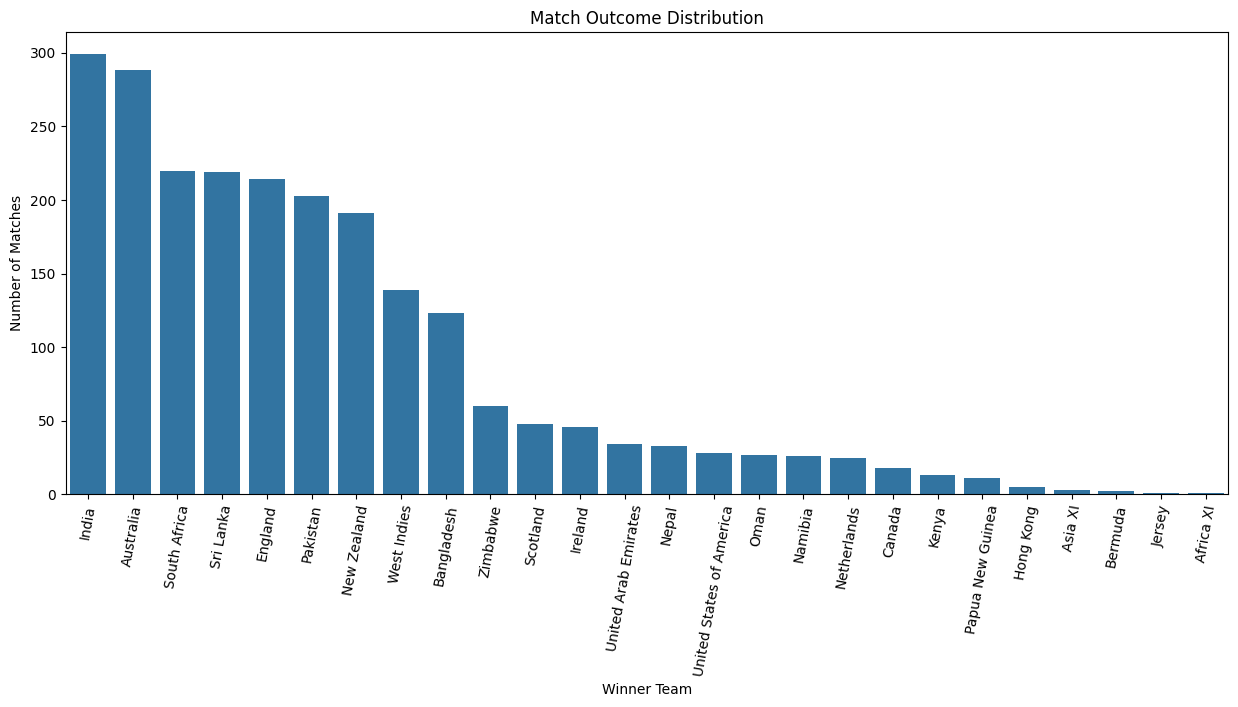

In [23]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='outcome_winner', order=df['outcome_winner'].value_counts().index)
plt.title('Match Outcome Distribution')
plt.ylabel('Number of Matches')
plt.xlabel('Winner Team')
plt.xticks(rotation=80)
plt.show()

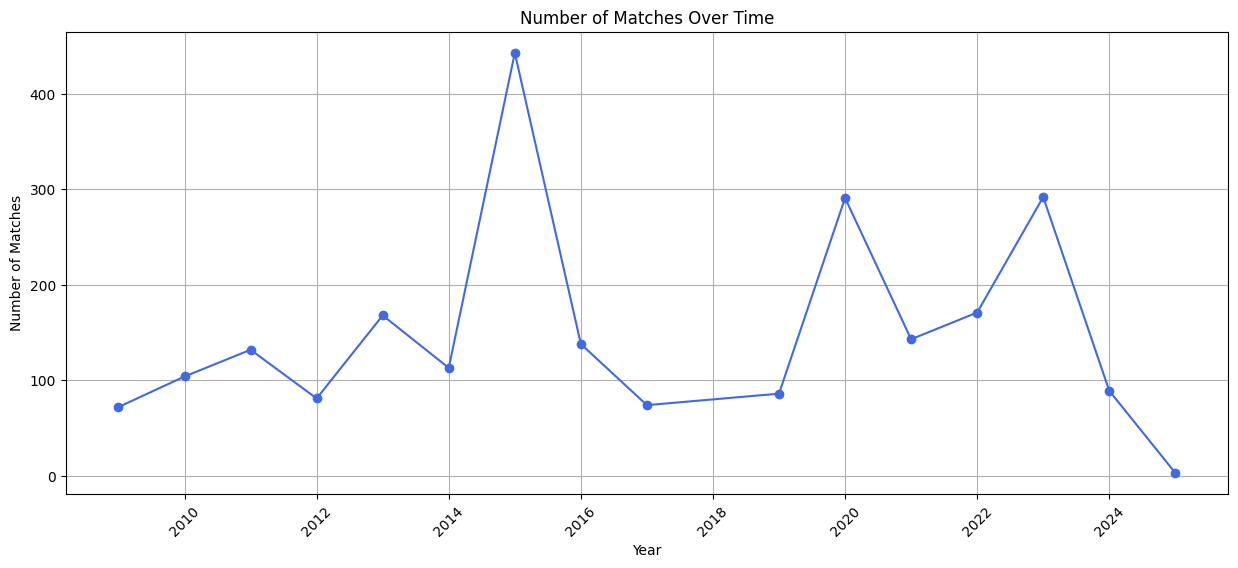

In [24]:
df['created'] = pd.to_datetime(df['created'])

# Match count over time (by year)
plt.figure(figsize=(15, 6))
df.groupby(df['created'].dt.year)['match_id'].count().plot(kind='line', color='royalblue', marker='o')
plt.title('Number of Matches Over Time')
plt.ylabel('Number of Matches')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

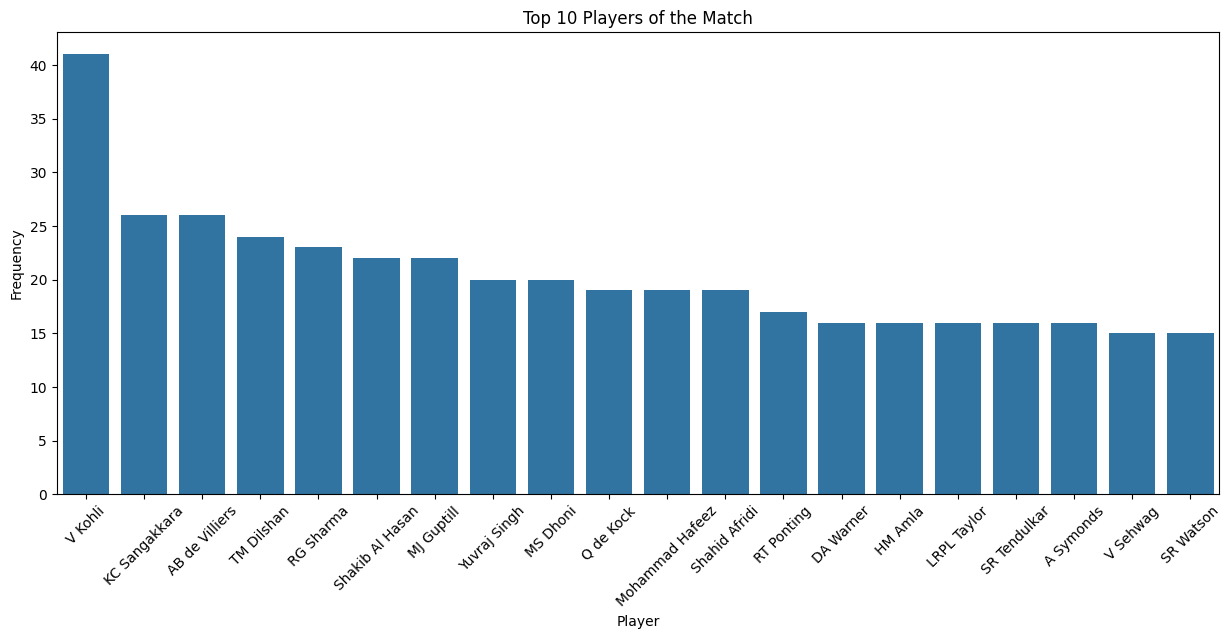

In [25]:
# Player of the match distribution
plt.figure(figsize=(15, 6))
top_players = df['player_of_match'].value_counts().head(20)
sns.barplot(x=top_players.index, y=top_players.values)
plt.title('Top 10 Players of the Match')
plt.xlabel('Player')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

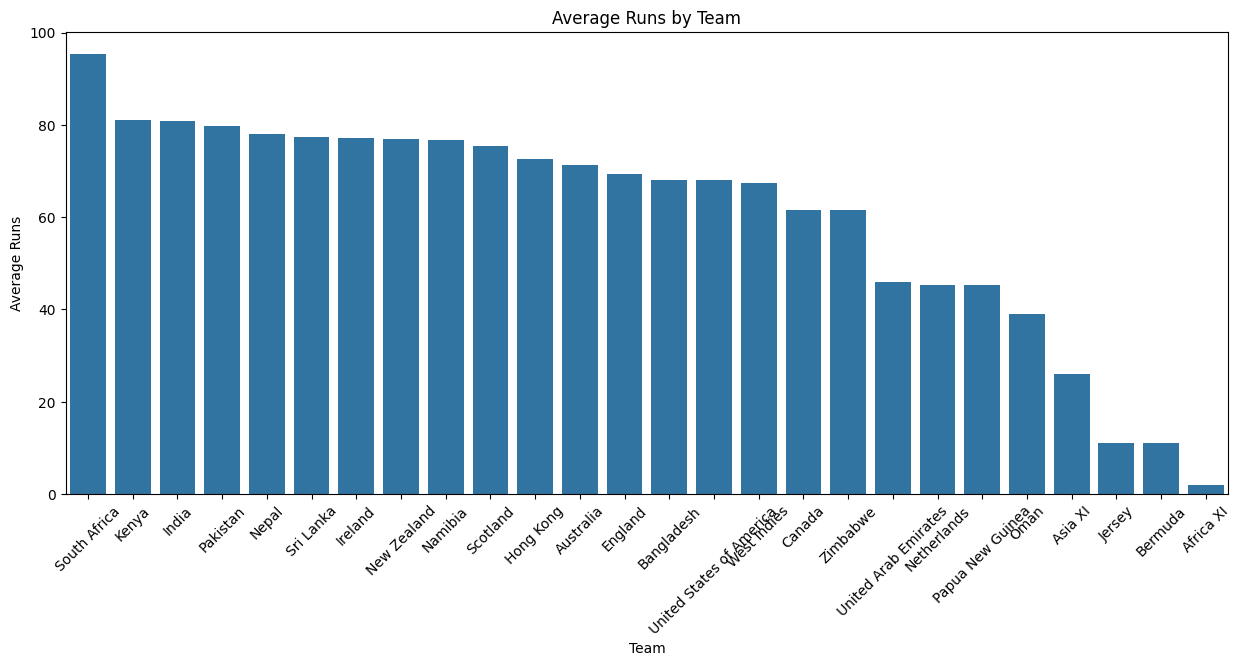

In [26]:
plt.figure(figsize=(15, 6))
team_avg_runs = df.groupby('outcome_winner')['outcome_by_runs'].mean().sort_values(ascending=False)
sns.barplot(x=team_avg_runs.index, y=team_avg_runs.values)
plt.title('Average Runs by Team')
plt.xlabel('Team')
plt.ylabel('Average Runs')
plt.xticks(rotation=45)
plt.show()

In [27]:
teams = df['teams'].str.split(', ', expand=True).stack().unique()
team_stats = {team: {'matches_played': 0, 'tosses_won': 0, 'matches_won': 0} for team in teams}

In [28]:
for index, row in df.iterrows():
    teams_in_match = row['teams'].split(', ')
    for team in teams_in_match:
        team_stats[team]['matches_played'] += 1
        
        if row['toss_winner'] == team:
            team_stats[team]['tosses_won'] += 1
        
        if row['outcome_winner'] == team:
            team_stats[team]['matches_won'] += 1

In [29]:
matches_df = pd.DataFrame.from_dict(team_stats, orient='index')
matches_df.reset_index(inplace=True)
matches_df.rename(columns={'index': 'team'}, inplace=True)

In [30]:
matches_df = matches_df[['team', 'matches_played', 'tosses_won', 'matches_won']]

matches_df['win_percentage'] = (matches_df['matches_won'] / matches_df['matches_played']) * 100
matches_df['toss_win_percentage'] = (matches_df['tosses_won'] / matches_df['matches_played']) * 100
matches_df['losses'] = matches_df['matches_played'] - matches_df['matches_won']
matches_df['draws'] = df[df['outcome_winner'].isna()]['teams'].apply(lambda x: [team for team in x.split(', ') if team in matches_df['team'].values]).apply(len).sum()  # Adjust this logic as necessary
matches_df['win_to_toss_ratio'] = matches_df['matches_won'] / matches_df['tosses_won'].replace(0, np.nan)

matches_df = matches_df.sort_values(by='win_percentage', ascending=False)

matches_df.head(10)

,team,matches_played,tosses_won,matches_won,win_percentage,toss_win_percentage,losses,draws,win_to_toss_ratio
3,Australia,460,233,288,62.608696,50.652174,172,246,1.236052
24,Asia XI,5,4,3,60.000000,80.000000,2,246,0.750000
0,India,505,246,299,59.207921,48.712871,206,246,1.215447
1,South Africa,373,193,220,58.981233,51.742627,153,246,1.139896
2,New Zealand,370,183,191,51.621622,49.459459,179,246,1.043716
15,Pakistan,396,195,203,51.262626,49.242424,193,246,1.041026
14,England,424,210,214,50.471698,49.528302,210,246,1.019048
20,Oman,55,29,27,49.090909,52.727273,28,246,0.931034
4,Nepal,68,38,33,48.529412,55.882353,35,246,0.868421
19,Scotland,99,46,48,48.484848,46.464646,51,246,1.043478


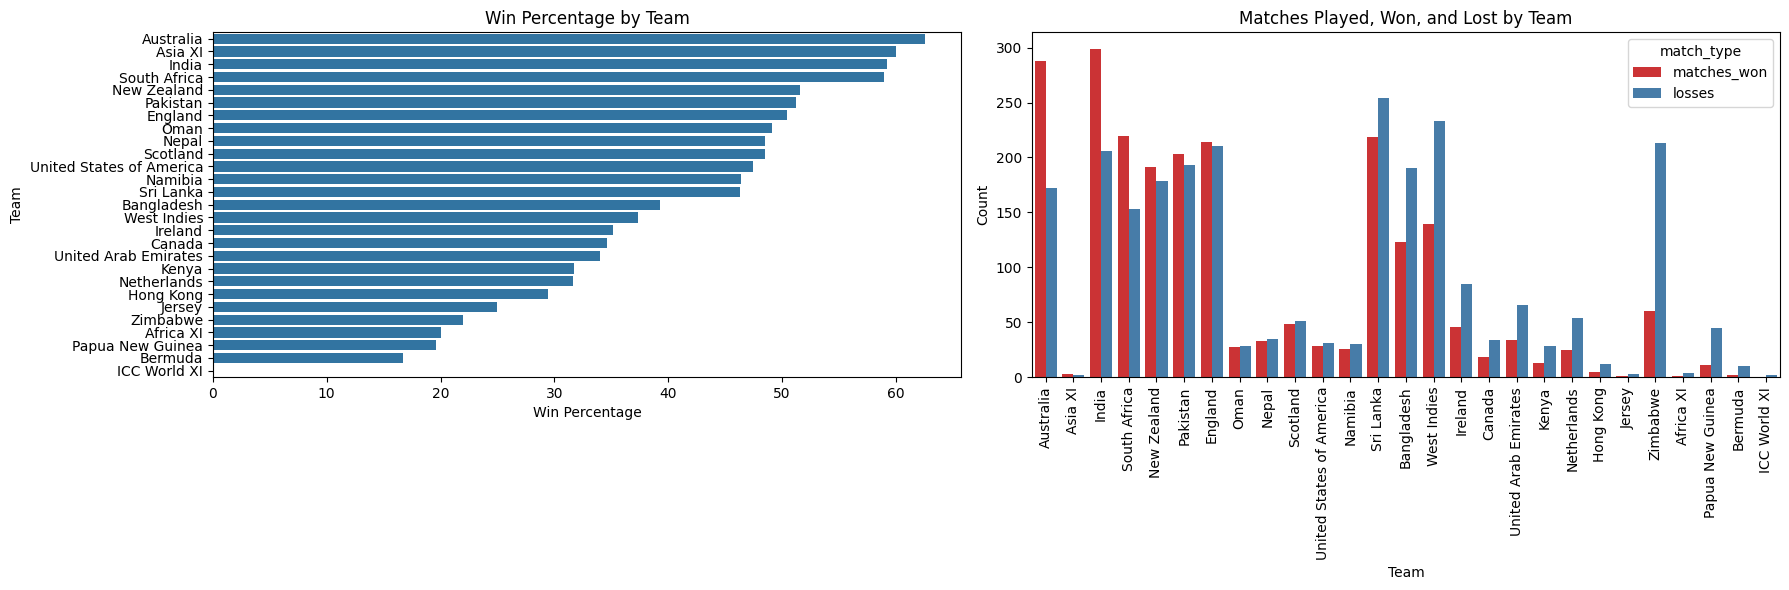

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(data=matches_df, y='team', x='win_percentage', ax=axes[0])
axes[0].set_title('Win Percentage by Team')
axes[0].set_xlabel('Win Percentage')
axes[0].set_ylabel('Team')

df_melted = matches_df.melt(id_vars='team', value_vars=['matches_won', 'losses'], var_name='match_type', value_name='count')
sns.barplot(data=df_melted, x='team', y='count', hue='match_type', palette='Set1', ax=axes[1])
axes[1].set_title('Matches Played, Won, and Lost by Team')
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Player analysis

In [32]:
batter_df = batter_df.sort_values(by=["total_runs", "strike_rate"], ascending=[False, False])
bowler_df = bowler_df.sort_values(by=["economy_rate", "total_wickets_taken"], ascending=False)

In [33]:
batter_df.head()

,player_name,role,total_runs,strike_rate,total_balls_faced,total_wickets_taken,total_runs_conceded,total_overs_bowled,total_matches_played,matches_played_as_batter,matches_played_as_bowler,matches_won,matches_lost,player_of_match_awards,team,average
16,V Kohli,Batter,13784,91.703812,15031,7,681,671,579,579,0,360,219,41,India,1969.142857
198,KC Sangakkara,Batter,11618,79.390461,14634,0,0,0,510,510,0,237,273,26,Sri Lanka,NaN
94,RG Sharma,Batter,10646,90.358173,11782,11,538,614,577,577,0,358,219,23,India,967.818182
195,MS Dhoni,Batter,10274,84.979322,12090,1,32,38,575,575,0,356,219,20,India,10274.000000
263,AB de Villiers,Batter,9435,99.441400,9488,7,205,201,466,466,0,286,180,26,South Africa,1347.857143


In [34]:
bowler_df.head()

,player_name,role,total_runs,strike_rate,total_balls_faced,total_wickets_taken,total_runs_conceded,total_overs_bowled,total_matches_played,matches_played_as_batter,matches_played_as_bowler,matches_won,matches_lost,player_of_match_awards,team,economy_rate,average
877,JPR Lamsam,Bowler,16,53.333333,30,0,27,12,218,0,218,126,92,0,India,2.250000,NaN
563,BJ Diamanti,Bowler,26,113.043478,23,0,25,12,494,0,494,346,148,0,Australia,2.083333,NaN
827,K Christie,Bowler,0,0.000000,3,0,18,9,36,0,36,7,29,0,Papua New Guinea,2.000000,NaN
873,LC Boylan,Bowler,31,65.957447,47,2,37,19,193,0,193,124,69,0,South Africa,1.947368,18.5
835,J Blades,Bowler,0,0.000000,0,0,73,39,190,0,190,70,120,0,Bangladesh,1.871795,NaN


## Batters analysis

In [35]:
sns.set_style('whitegrid')

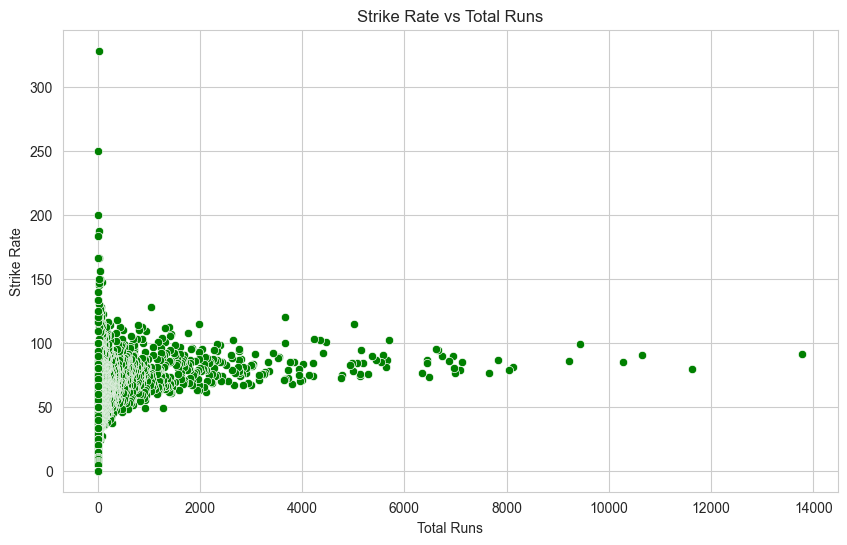

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_runs', y='strike_rate', data=batter_df, color='green')
plt.title('Strike Rate vs Total Runs')
plt.xlabel('Total Runs')
plt.ylabel('Strike Rate')
plt.show()

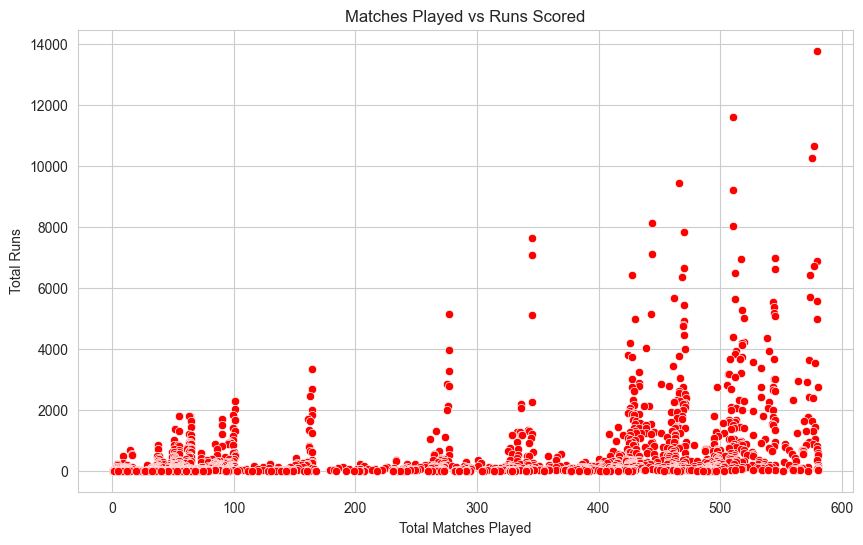

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_matches_played', y='total_runs', data=batter_df, color='red')
plt.title('Matches Played vs Runs Scored')
plt.xlabel('Total Matches Played')
plt.ylabel('Total Runs')
plt.show()

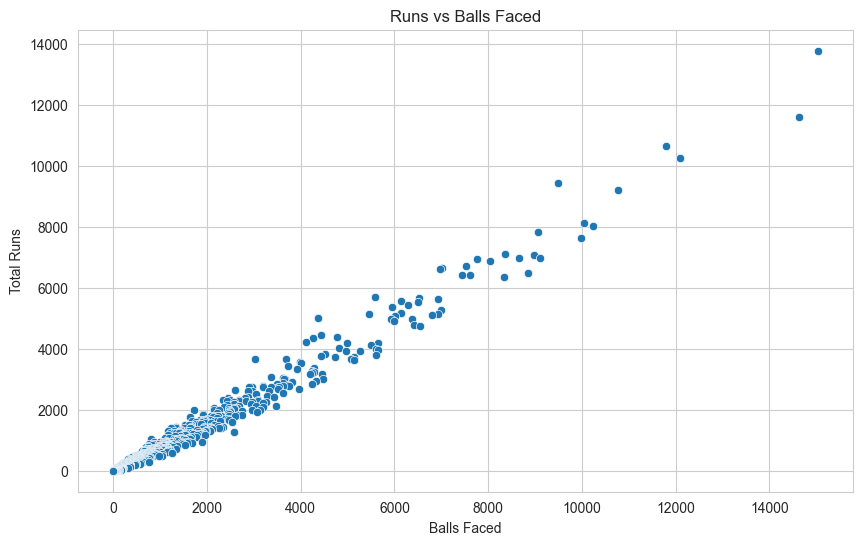

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_balls_faced', y='total_runs', data=batter_df)
plt.title('Runs vs Balls Faced')
plt.xlabel('Balls Faced')
plt.ylabel('Total Runs')
plt.show()

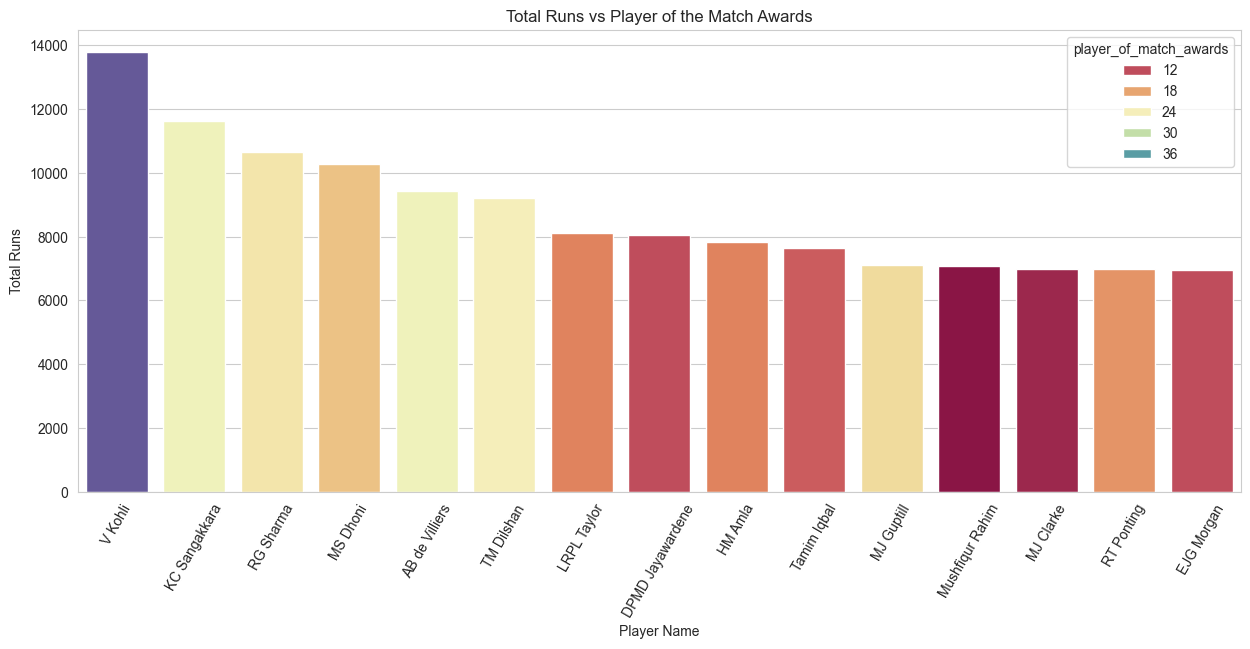

In [39]:
plt.figure(figsize=(15, 6))
sns.barplot(x='player_name', y='total_runs', data=batter_df.sort_values(by='total_runs', ascending=False).head(15), hue='player_of_match_awards', palette='Spectral')
plt.title('Total Runs vs Player of the Match Awards')
plt.xlabel('Player Name')
plt.ylabel('Total Runs')
plt.xticks(rotation=60)
plt.show()

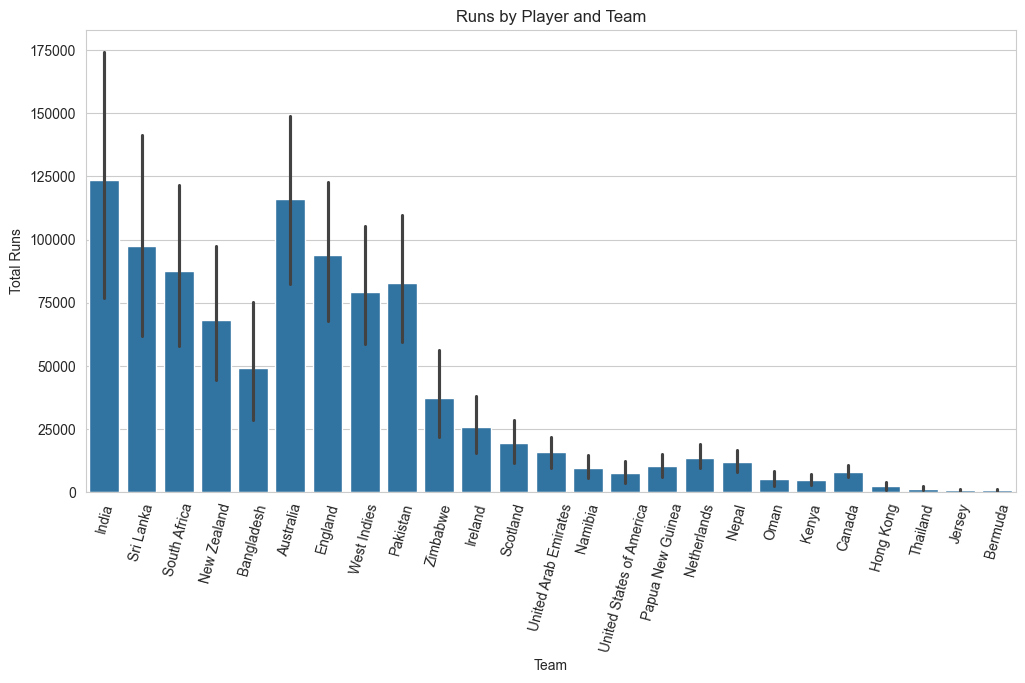

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(x='team', y='total_runs', data=batter_df, estimator='sum')
plt.title('Runs by Player and Team')
plt.xlabel('Team')
plt.ylabel('Total Runs')
plt.xticks(rotation=75)
plt.show()

# Maths analysis

In [41]:
df_summary.sort_values(by='outcome_by_runs', ascending=False).head()

,match_id,created,city,dates,event_name,match_number,gender,match_type,match_type_number,toss_winner,...,outcome_winner,outcome_by_runs,outcome_by_wickets,overs,player_of_match,season,teams,venue,total_fours,total_sixes
1216,1348645,2023-01-17,Thiruvananthapuram,2023-01-15,Sri Lanka tour of India,3.0,male,ODI,4505,India,...,India,317.0,NaN,50,V Kohli,2022/23,"India, Sri Lanka","Greenfield International Stadium, Thiruvananth...",43,14
1890,1384415,2023-10-26,Delhi,2023-10-25,ICC Cricket World Cup,24.0,male,ODI,4681,Australia,...,Australia,309.0,NaN,50,GJ Maxwell,2023/24,"Australia, Netherlands","Arun Jaitley Stadium, Delhi",55,15
2264,1145892,2020-07-16,Dublin,2018-06-10,New Zealand Women tour of Ireland and England,2.0,female,ODI,1117,New Zealand,...,New Zealand,306.0,NaN,50,None,2018,"New Zealand, Ireland",The Vineyard,62,9
1539,1377762,2023-06-26,Harare,2023-06-26,ICC Cricket World Cup Qualifier,17.0,male,ODI,4601,United States of America,...,Zimbabwe,304.0,NaN,50,SC Williams,2023,"Zimbabwe, United States of America",Harare Sports Club,47,15
2134,1459899,2025-01-15,Rajkot,2025-01-15,Ireland Women tour of India,3.0,female,ODI,1434,India,...,India,304.0,NaN,50,Pratika Rawal,2024/25,"India, Ireland","Saurashtra Cricket Association Stadium, Rajkot",64,9


In [42]:
ids = list(df_summary.sort_values(by='outcome_by_runs', ascending=False).head(5)["match_id"])
ids

['1348645', '1384415', '1145892', '1377762', '1459899']

In [43]:
def plot_match_runs_and_wickets(match_id):
    """
    Plots a line chart of cumulative runs scored by both teams in a match and marks wickets with red dots.

    Parameters:
    - match_id (str or int): The ID of the match to plot.
    - csv_folder (str): The folder where the CSV files are stored.
    """
    csv_file_path = os.path.join(csv_folder, f"{match_id}.csv")
    
    if not os.path.exists(csv_file_path):
        print(f"Error: CSV file for match ID {match_id} not found in the folder {csv_folder}.")
        return
    
    df = pd.read_csv(csv_file_path)
    
    teams = df['team'].unique()
    
    plt.figure(figsize=(18, 6))
    ax = plt.gca()
    
    for team in teams:
        team_df = df[df['team'] == team].copy()
        team_df['cumulative_runs'] = team_df['runs_total'].cumsum()
        ax.plot(team_df.index, team_df['cumulative_runs'], label=f'{team} Cumulative Runs')
        
        # Mark wickets with red dots
        wickets = team_df[pd.notna(team_df['wicket_kind'])]
        ax.scatter(wickets.index, wickets['cumulative_runs'], color='red', label='Wicket' if team == teams[0] else "")
    
    ax.set_xlabel('Ball Number')
    ax.set_ylabel('Cumulative Runs')
    ax.set_title(f'Match ID {match_id}: Runs Scored and Wickets')
    
    ax.legend(loc='upper left')
    plt.show()

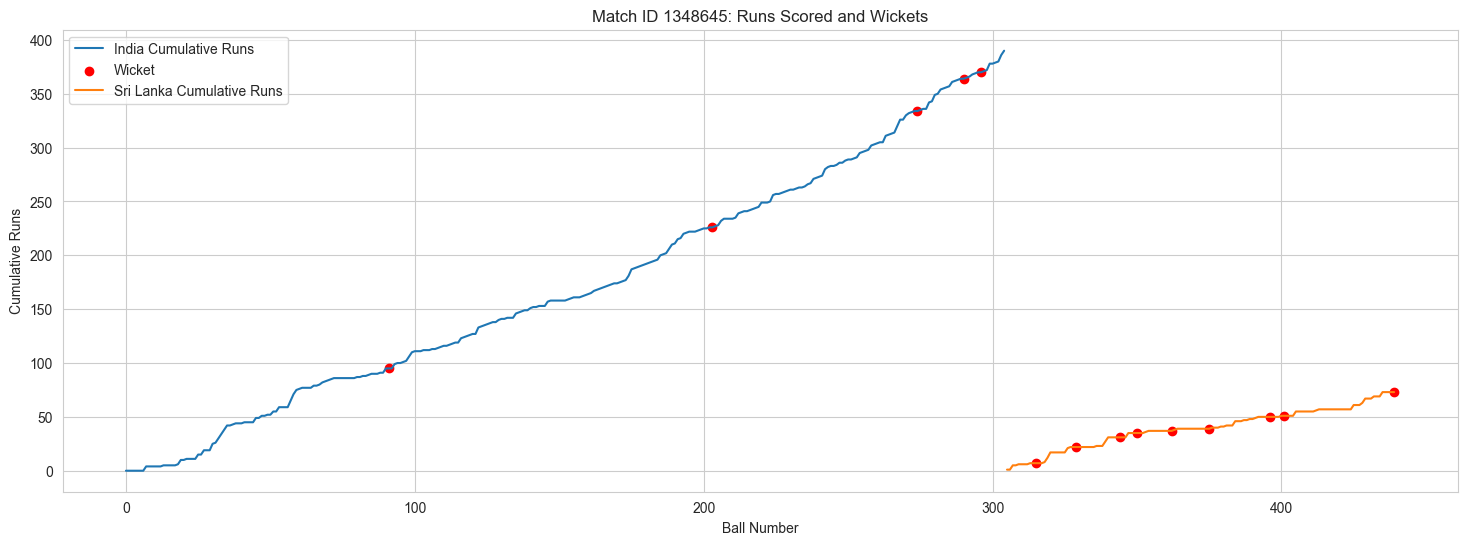

In [44]:
plot_match_runs_and_wickets(ids[0])

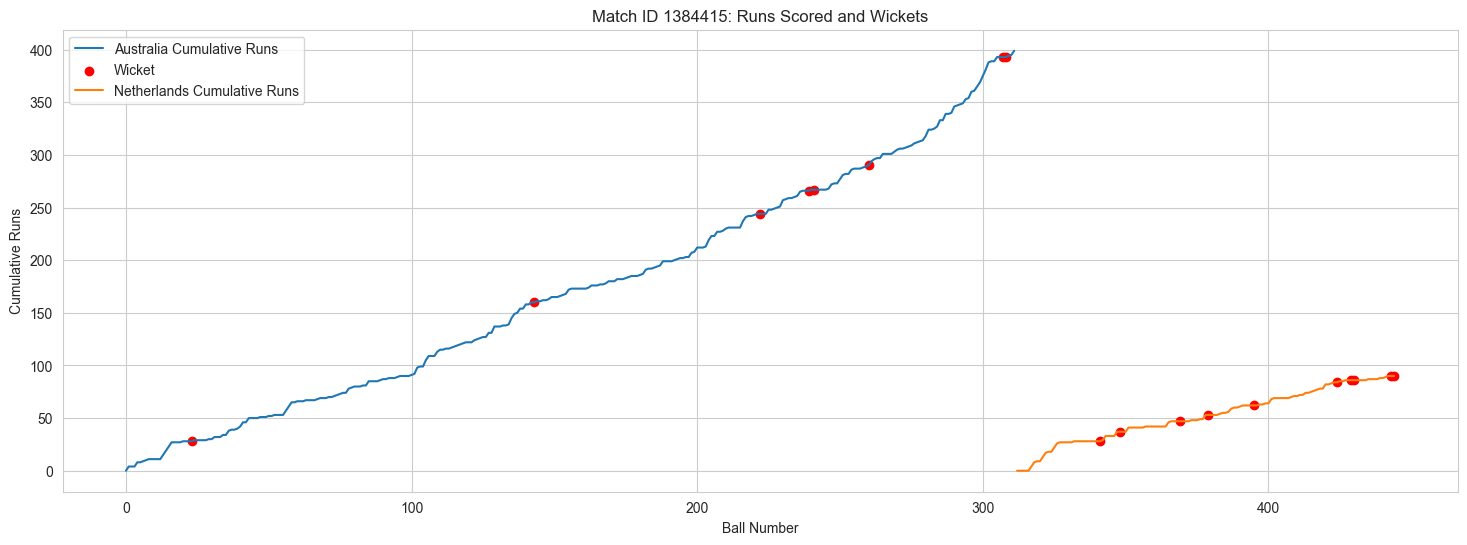

In [45]:
plot_match_runs_and_wickets(ids[1])

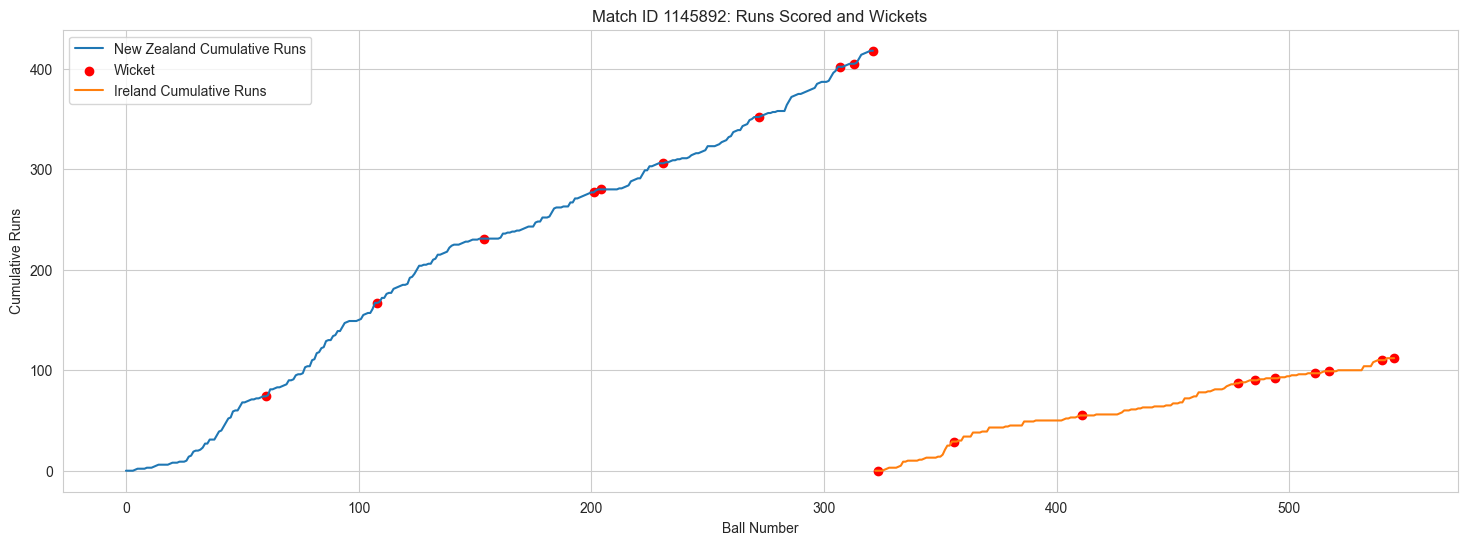

In [46]:
plot_match_runs_and_wickets(ids[2])

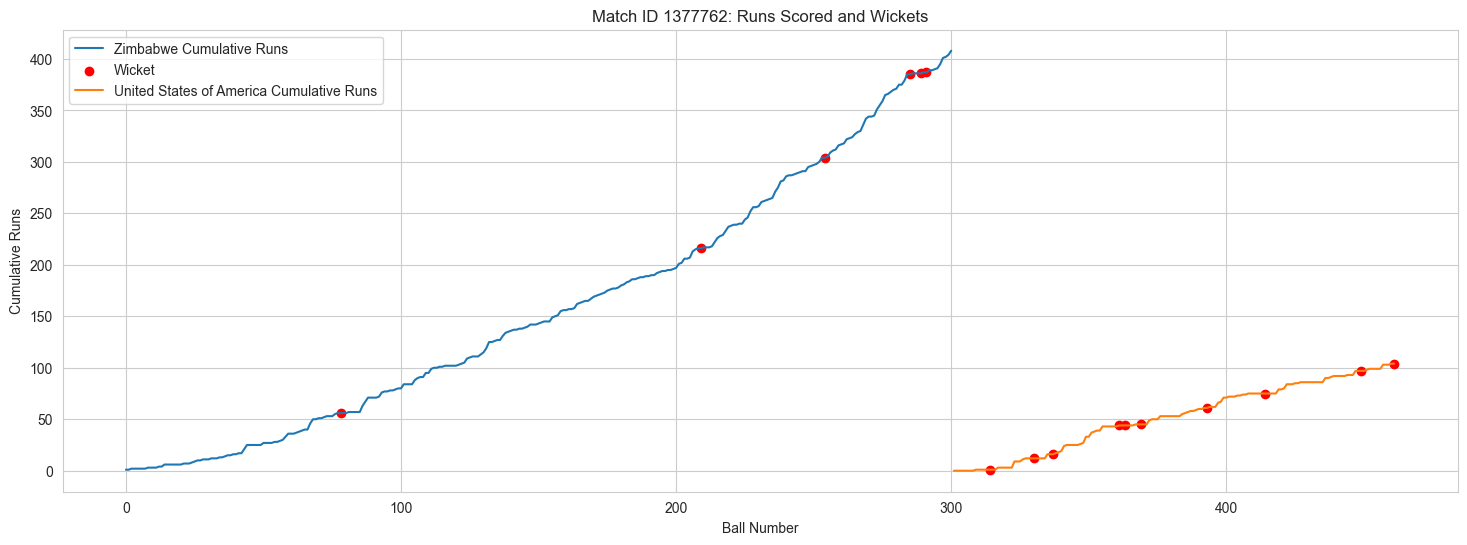

In [47]:
plot_match_runs_and_wickets(ids[3])

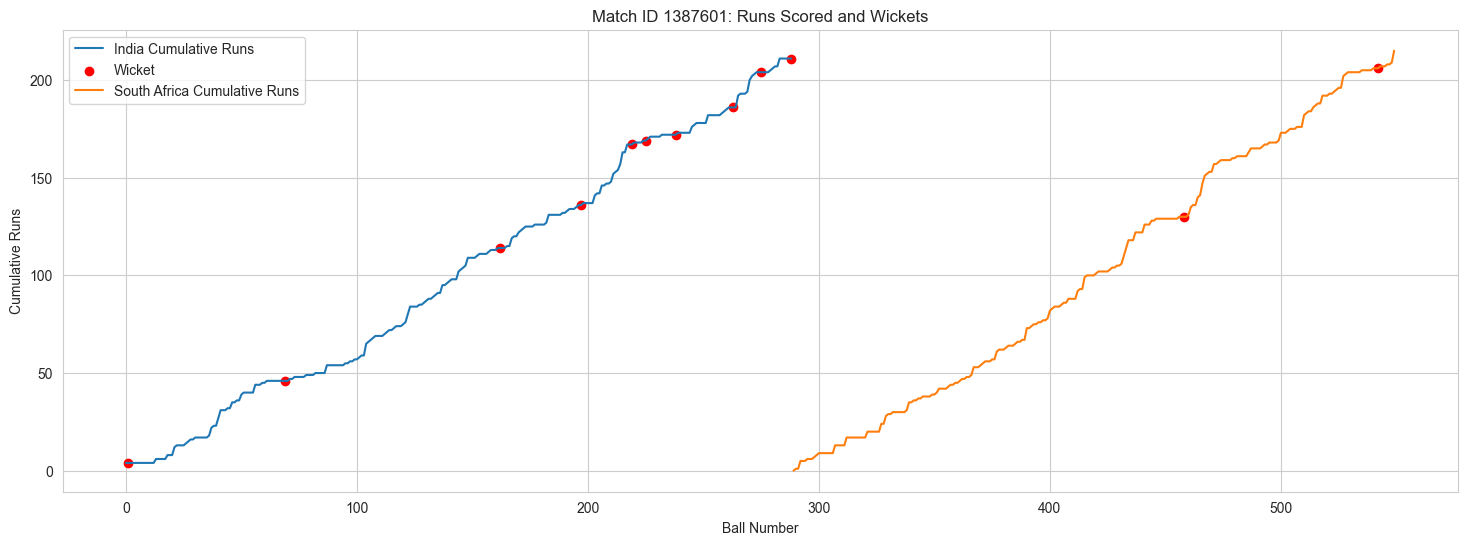

In [48]:
plot_match_runs_and_wickets(1387601)

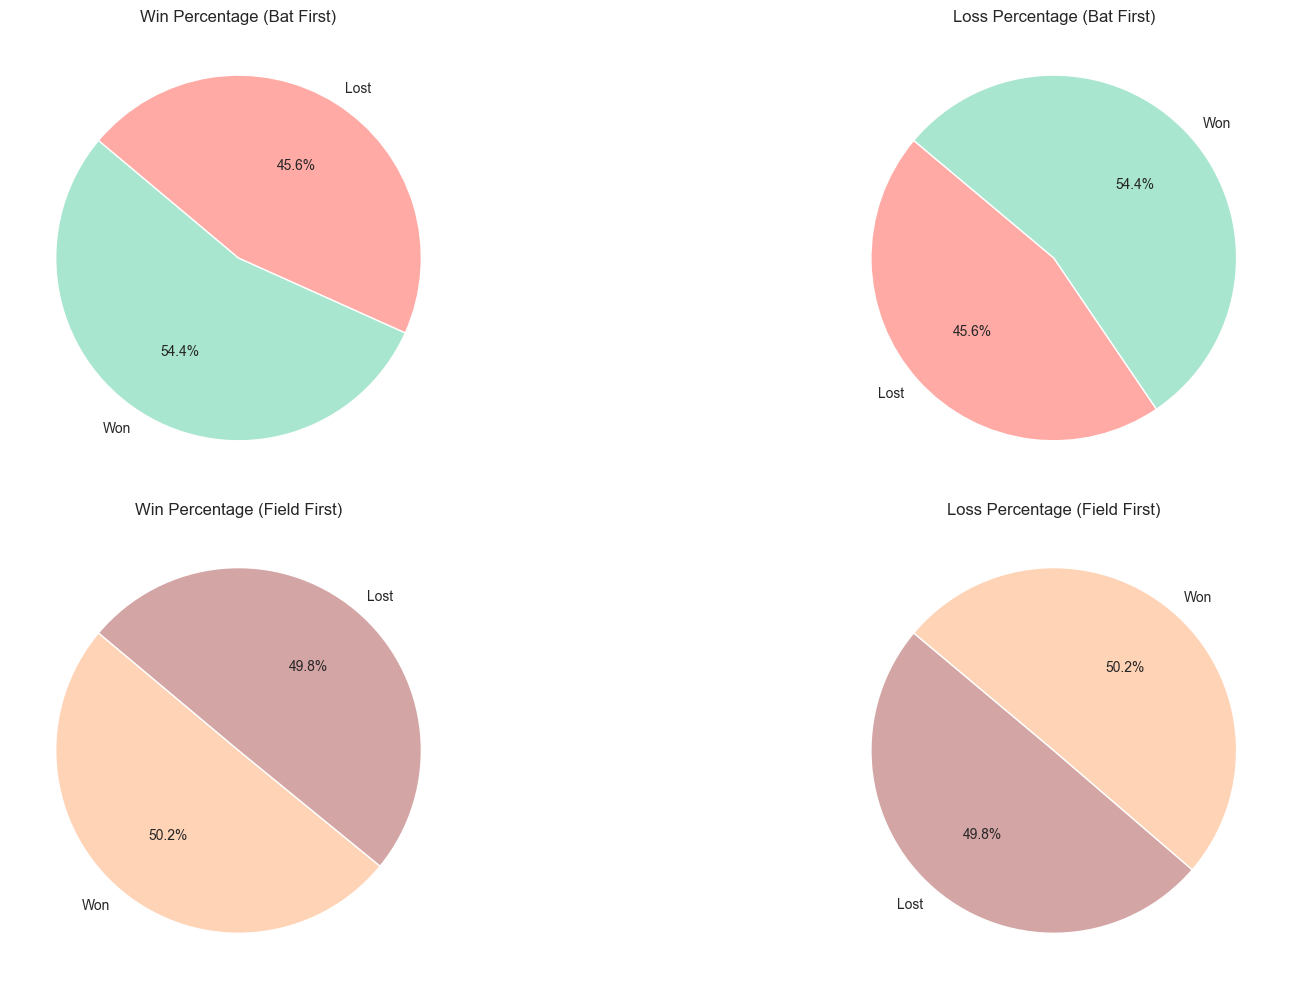

In [49]:
df_summary['toss_winner_won'] = df_summary['toss_winner'] == df_summary['outcome_winner']

batting_stats = df_summary[df_summary['toss_decision'] == 'bat']['toss_winner_won'].value_counts(normalize=True) * 100
fielding_stats = df_summary[df_summary['toss_decision'] == 'field']['toss_winner_won'].value_counts(normalize=True) * 100

labels = ['Won', 'Lost']

bat_colors = ['#A8E6CF', '#FFAAA5']  # Light green & soft red
field_colors = ['#FFD3B6', '#D4A5A5']  # Soft peach & muted red

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].pie(batting_stats, labels=labels, autopct='%1.1f%%', colors=bat_colors, startangle=140)
axes[0, 0].set_title("Win Percentage (Bat First)")

axes[0, 1].pie(batting_stats[::-1], labels=labels[::-1], autopct='%1.1f%%', colors=bat_colors[::-1], startangle=140)
axes[0, 1].set_title("Loss Percentage (Bat First)")

axes[1, 0].pie(fielding_stats, labels=labels, autopct='%1.1f%%', colors=field_colors, startangle=140)
axes[1, 0].set_title("Win Percentage (Field First)")

axes[1, 1].pie(fielding_stats[::-1], labels=labels[::-1], autopct='%1.1f%%', colors=field_colors[::-1], startangle=140)
axes[1, 1].set_title("Loss Percentage (Field First)")

plt.tight_layout()
plt.show()

# Player data analysis

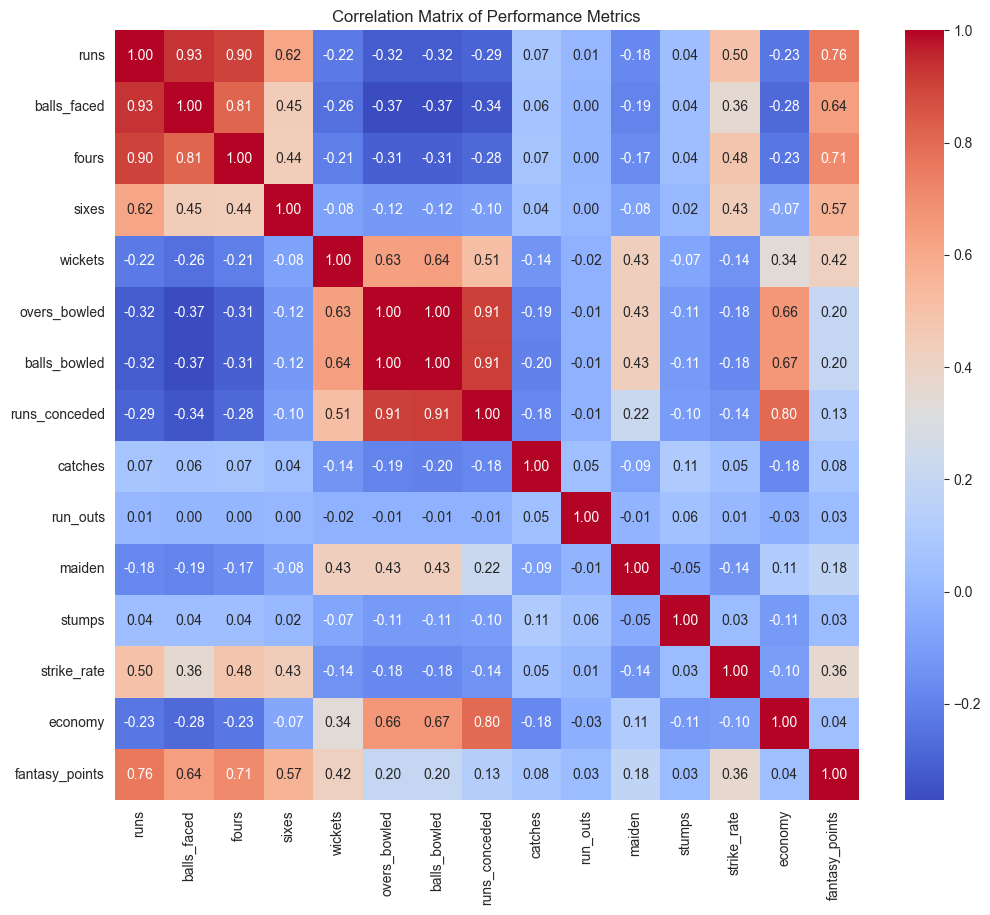

In [50]:
columns_of_interest = ["runs", "balls_faced", "fours", "sixes", "wickets", "overs_bowled",
                       "balls_bowled", "runs_conceded", "catches", "run_outs", "maiden",
                       "stumps", "strike_rate", "economy", "fantasy_points"]

corr_matrix = players_detailed_stats[columns_of_interest].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Performance Metrics")
plt.show()